# Лабораторная работа №1: Основы цифровой обработки сигналов

#### Выполнил студент гр. 9381 Семенов Александр, вариант 15.

## Цель работы
#### Изучить возможности библиотек Python для решения задач цифровой обработки сигналов.

## Задачи лабораторной работы

##### 1. Освоить Jupyter Notebook.
##### 2. Выполнить загрузку аудио сигнала и построить огибающую (график).
##### 3. Фильтрация (выбрать один из 4 основных типов фильтров). Получить фильтрованный сигнал.
##### 4. Детектор сигнал/шум. Получить сигнал после детектирования
##### 5. Эффект ”Эхо”. Получить сигнал после работы аудио-эффекта.
##### 6. Бонусное задание: эффект ”Distortion”(классический вариант). Получить сигнал после работы аудио-эффекта.

## Выполнение работы

### 1. Загрузка аудио-сигнала и построение огибающей
#### Основные теоретические положения:
Имеется сигнал $x(i)$, $i \in [0, N-1]$

Хотим построить огибающую $y(j)$, $j \in [0, n-1]$

Пусть $m = \displaystyle{\bigg\lbrack\frac{N}{n}\bigg\rbrack}$ - число точек в интервале усреднения.

Тогда $y(j) = \displaystyle\frac{1}{m}\sum_{k=mj}^{mj+m-1} |x(k)|$

#### Реализация:

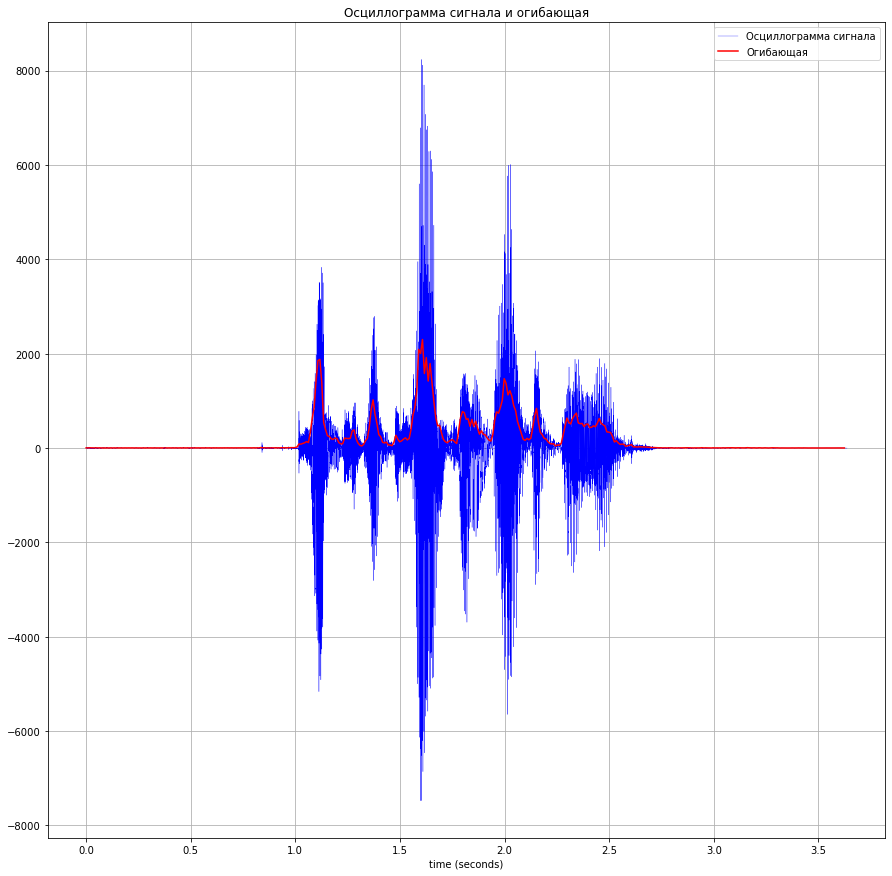

In [163]:
import wave
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio

def paintGraphics(data, framerate, b, a = 0):
    # a - Правая граница
    # b - Левая граница

    N = b - a # Вычисляем количество точек осциллограммы сигнала
    n = 400 # Задаем количество точек огибающей
    m = int(N/n) # Вычисляем число точек в интервале усреднения
    x = data[a:b] # Строим массив значений осциллограммы сигнала
    y = [np.mean([abs(x[k]) for k in range(m*j, m*(j+1))]) for j in range(n)] # Строим список значений огибающей

    timeSignal = np.arange(a, b) / framerate # Строим массив точек времени для осциллограммы сигнала
    timeOgib = np.arange(a, m*n + a, m) / framerate # Строим массив точек времени для огибающей

    plt.figure(figsize = [15, 15])
    plt.plot(timeSignal, x, color = 'blue',  linewidth = 0.3, label = "Осциллограмма сигнала") # Строим осциллограмму сигнала
    plt.plot(  timeOgib, y, color = 'red',   linewidth = 1.5, label = "Огибающая") # Строим огибающую
    plt.legend()
    plt.xlabel("time (seconds)")
    plt.title("Осциллограмма сигнала и огибающая")
    plt.grid()

    plt.show()

    
# Включить аудио WAV
f = wave.open(r"03-01-05-01-01-01-15_A15.wav", "rb")

# Читать информацию о формате
# (Количество каналов, биты квантования, частота дискретизации, точки выборки, тип сжатия, описание типа сжатия)
# (nchannels, sampwidth, framerate, nframes, comptype, compname)
parametres = f.getparams()
nchannels, sampwidth, framerate, nframes, comptype, compname = parametres

# Получение одномерного массива коротких типов
data = np.frombuffer(f.readframes(nframes), dtype=np.short)
f.close()

paintGraphics(data, framerate, nframes)
#paintGraphics(data, framerate, 135000, 40000)
Audio(data, rate = framerate)

### 2. Фильтрация
#### Основные теоретические положения:

Существуют 4 основных типов фильтра:
- фильтр нижних частот (ФНЧ)
- фильтр верхних частот (ФВЧ)
- полосовой фильтр
- режекторный фильтр

Фильтр верхних частот подавляет частоты сигнала ниже частоты среза данного фильтра.

Пусть $F_d$ - частота дискретизации сигнала, $F_s$ - частота среза.Порядок фильтра - $m$.

Тогда: $wn = \displaystyle{2\frac{F_s}{F_d}}$ - относительная частота среза

**Задача:** Выбрать один из 4 типов фильтров (фильтр верхних частот), эксперементально подобрать частоту среза (3300 Гц) и преобразовать сигнал.

#### Реализация ФВЧ:

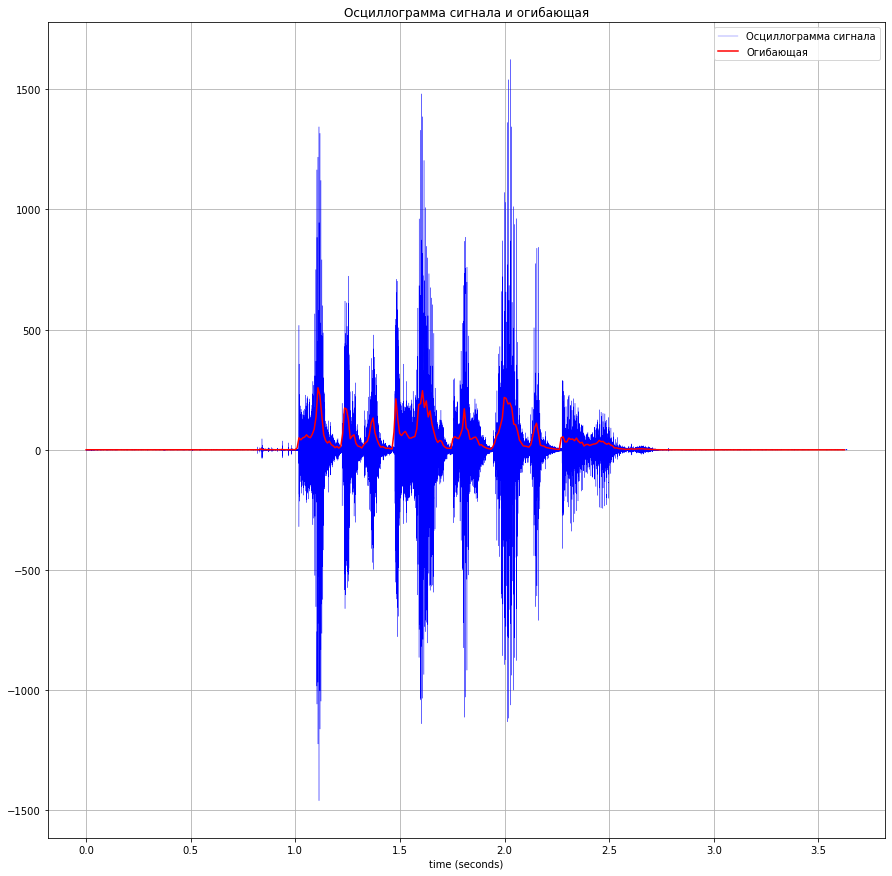

In [157]:
from scipy import signal

def recordFixed(fileName, parametres, fixedData):
    f = wave.open(fileName + ".wav", "wb") # Создание и открытия нового файла для записи
    f.setparams(parametres) # Установка параметров
    f.writeframes(fixedData) # Запись отфильтрованного звука в файл
    f.close()
    
def _filter_(data, mode):
    F_s = 3300 # Частота среза
    m = 1 # Порядок фильтра

    F_d = 48_000 # Частота дискретизации
    wn = 2 * F_s / F_d # Относительная частота среза
    b, a = signal.butter(m, wn, mode)
    return np.short(signal.filtfilt(b, a, data)) # Вычисление отфильтрованного сигнала

filterData = _filter_(data, mode = 'highpass')

recordFixed("filtered", parametres, filterData)
paintGraphics(filterData, framerate, nframes)
Audio(filterData, rate = framerate)

### 3. Амплитудный детектор (сигнал/шум)

Зачищает сигнал от лишнего шума

#### Задание:

1) Определяем среднее сигнала по амплитуде (без учета знака):

$mid = \displaystyle{\frac{1}{N}\sum_{k=0}^{N-1}|x(k)|}$

2) Определяем порог детектора: 

$Th = \alpha \cdot mid$, где $\alpha \in (0, 1)$ - подбирается эксперементально

3) Задаем величину провала (в отсчетах) - $k$

4) Обозначим $y(i)$ - сигнал после детектирования

Тогда последний рассчитывается по следующему правилу:
- **Событие "начало сигнала":** Если $x(i)$ в течении $k$ отсчетов превышает порог, то $y(i) = x(i)$
- **Событие "окончание сигнала":** Если $x(i)$ в течении $k$ отсчетов меньше порога, то $y(i) = 0$.

#### Реализация:

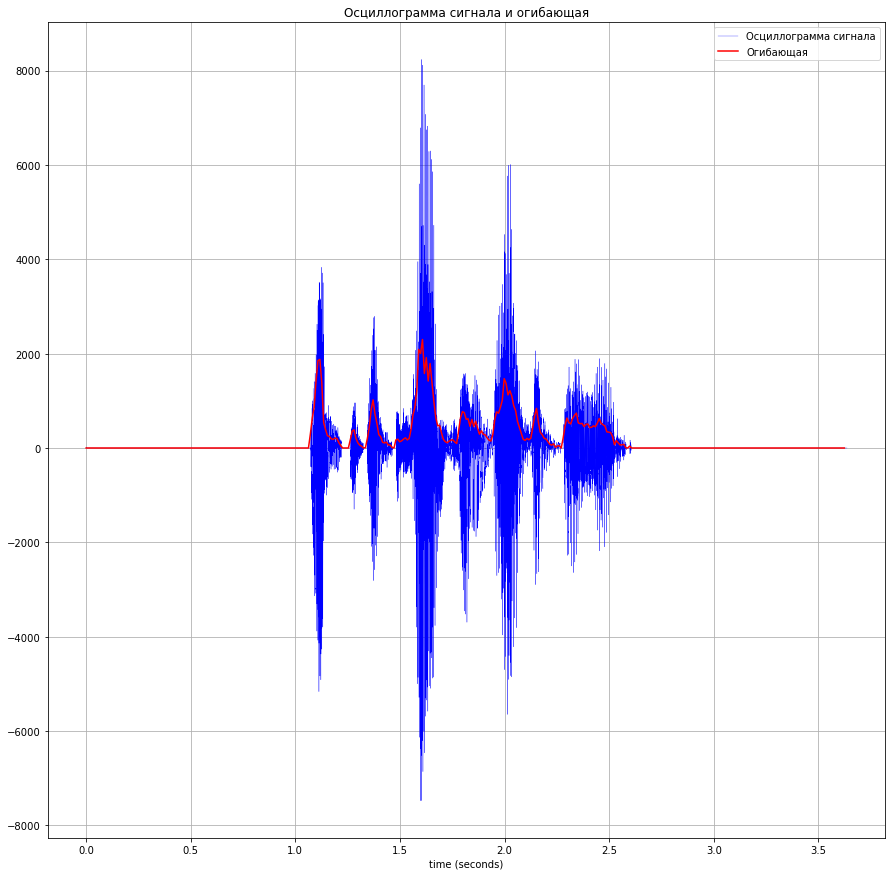

In [158]:
a = 0.25
k = 50 # Величина провала (в отчсчетах)

mid = np.average(abs(data)) # Среднее сигнала по амплитуде
Th = a * mid # Порог детектора

y = [] # Задаем результирующий вектор обработанного сигнала

isSignal = True # Индикатор режима сигнала
prev = Th # Задаем начальное предыдущее значение
count = 0 # Счетчик отсчетов
for i in data:
    if abs(prev) >= Th and abs(i) < Th or abs(prev) < Th and abs(i) >= Th:
        count = 0 # Обнуление счетчика при смене знака
    count += 1 # Очередное начисление счетчика
    if count >= k:
        isSignal = (abs(i) >= Th) # Обновление режима при достижении k отчетов сигнала выше или ниже порога
    if (isSignal):
        y.append(i)           # Добавление в новый вектор очередного элемента сигнала
    else:
        y.append(np.short(0)) # в зависимости от режима
    prev = i # Запоминание предыдущего значения

detecterData = np.array(y)

recordFixed("detectered", parametres, detecterData)
paintGraphics(detecterData, framerate, nframes)
Audio(detecterData, rate = framerate)

### 4. Эхо (простейший ревербератор)

#### Основные теоретические положения:

- Ревербератор реализован, как набор линий задержки. Число линий задержки $N_L \geqslant 8$ Каждая линия задержки имеет свой весовой коэффициент (задается пользователем):
$\alpha_1 > \alpha_2 > ... > \alpha_{L_N}$
- Перед добавлением к исходному сигналу, выход ревербератора фильтруется
ФНЧ-фильтром первого порядка.
- Желаемое соотношение между ”сухим”и обработанным сигналом задается
коэффициентом применимости $\gamma$.
- Ревербератор может работать в двух режимах: ручной и с использованием готовой конфигурации (preset). Для ручного режима регулируется пользователем задается максимальная задержка $D_1$, а величины остальных определяются автоматически через нее:

$D_i = D_1 2^{\displaystyle{\frac{1-i}{N_L}}}$, $i \in [2, N_L]$

- Для готовой конфигурации пользователь вручную задает последовательность:

$D_1 > D_2 > ... > D_{L_N}$

- Начальное значение $D_1$ определяется геометрией помещения, и является расстоянием, пройденным звуком (скорость 335 м/сек) от точки излучения до ближайшего препятствия, домноженным на $2$:

$D_1 = \displaystyle{F_d \frac{2S}{\upsilon_{звука}}}$, где $S$ - расстояние до ближайшей стены от источника и приемника звука

#### Реализация:

**Пояснение:** Требуется ввести в программу длинну до ближайшей стены от источника в метрах. Наиболее подходящие числа для моделирования двух различных ситуаций:
- 7 м - звук в ванной комнате;
- 20 м - звук в зале через микрофон или в большом ремонтируемом помещении.

Введите расстояние до ближайшей стены (в местрах): 20


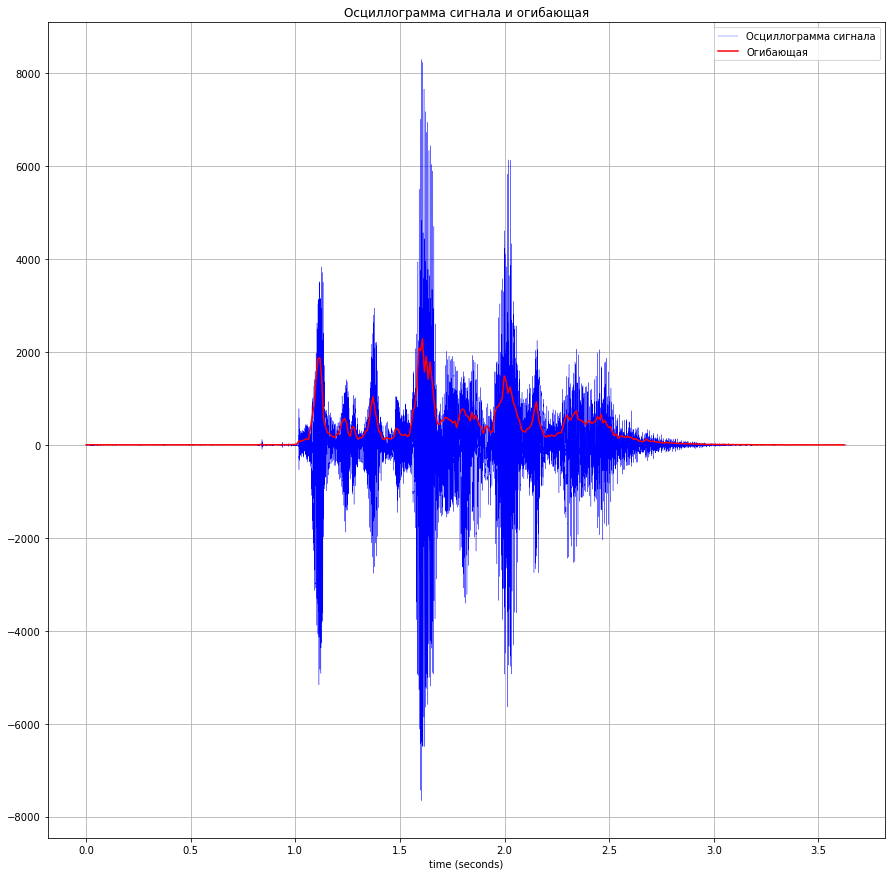

In [160]:
alpha = [0.96, 0.48, 0.24, 0.12, 0.06, 0.03, 0.02, 0.01, 0.005, 0.001, 0.0001] # Весовые коэффициенты
gamma = 0.3 # Коэффициент применимости

lenForWall = int(input('Введите расстояние до ближайшей стены (в местрах): ')) # Длинна до ближайшей стены (в метрах) //7 или 20
soundSpeed = 335 # Приблизительная скорость звука
D_1 = 2 * framerate * lenForWall / soundSpeed # Рассчет максимальной задержки

newData = list(data) # Начальный вектор задержки
summ = np.array([np.short(0) for i in range(len(data))]) # Нулевой вектор суммирования сигналов
for i in range(len(alpha)):
    D_i = int(D_1 * 2**(-i/len(alpha))) # Рассчет i-ой задержки методом логарифмического затухания
    newData = ([np.short(0) for j in range(D_i)] + newData)[:len(newData)] # Рассчет нового вектора задержки по предыдущему
    summ = summ + np.short(np.array(newData) * alpha[i]) # Добавление к вектору суммирования очередного задержанного и приглушенного сигнала

reverbData = np.short(_filter_(summ, mode = 'lowpass') * gamma) + data # Фильтрация суммированного сигнала, домножение на вклад реверберированного сигнала
                                                                       # и добавление его к исходному сигналу
recordFixed("reverbed", parametres, reverbData)
paintGraphics(reverbData, framerate, nframes)
Audio(reverbData, rate = framerate)

### 5. Классический Distortion (опционально)

### Основные теоретические положения:

**Дисторшн** - звуковой эффект, достигаемый искажением сигнала путём его «жёсткого» ограничения по амплитуде, в основе которого лежит клиппирование. Эффект добавляет в сигнал дополнительные гармоники и обертоны, насыщая звук, делая его более богатым.

Обозначим входной и выходной сигналы соответственно, как $x(i)$ и $y(i)$, $i \in [0, N-1]$

Пользователь задает порог $Th$ и максимальное значение сигнала $Max > Th$. Тогда:

$ y(i) =
  \begin{cases}
    x(i), & \quad |x(i)| \leqslant Th \\
    Max \cdot sign(x(i)), & \quad |x(i)| > Th
  \end{cases}
$

### Реализация:

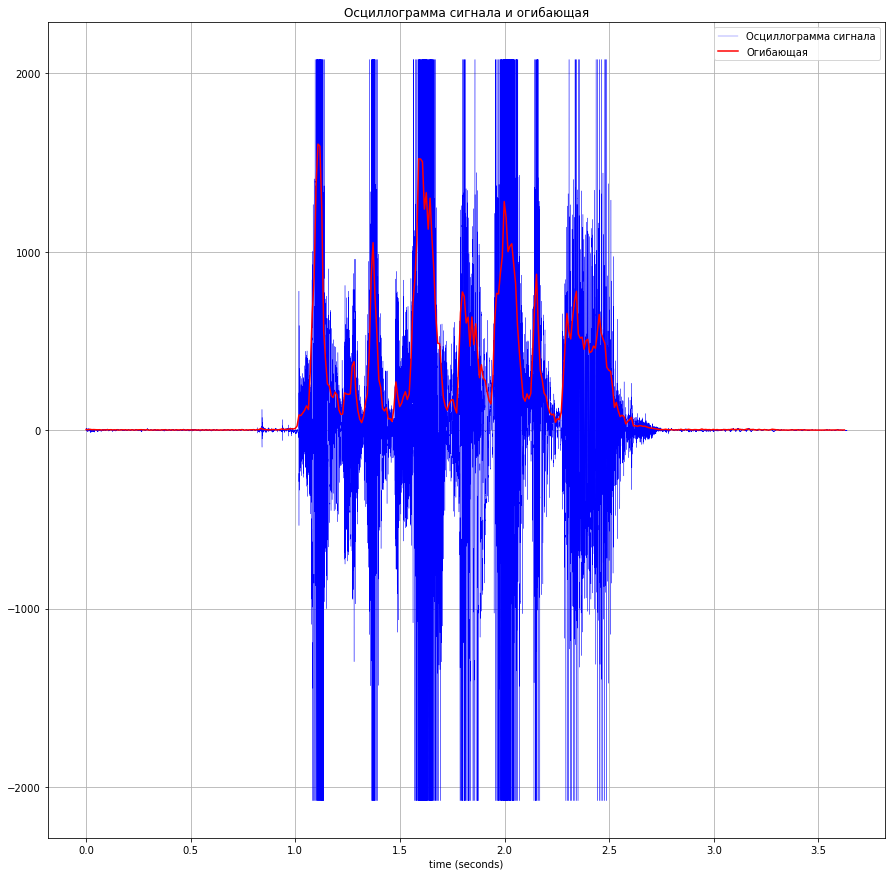

In [161]:
average = np.mean(abs(data)) # Вычисление среднего значения по амплитуде сигнала

Th = 7 * average # Порог
Max = 10 * average # Максимальное значение сигнала

distortData = list(data)
for i in range(len(distortData)):
    if abs(distortData[i]) > Th: # Если сигнала по модулю выше порога, то усиляем его
        distortData[i] = np.short(Max * round(distortData[i] / abs(distortData[i])))

distortData = np.array(distortData)
        
recordFixed("distorted", parametres, distortData)
paintGraphics(distortData, framerate, nframes)
Audio(distortData, rate = framerate)

## Вывод
#### В ходе выполнения лабораторной работы были изучены возможности библиотек Python для решения задач цифровой обработки сигналов, приобретены навыки в использовании Jupiter Notebook и $LaTeX$, а также решены следующие задачи:
- __Загрузка аудио-сигнала;__
- __Построение огибающей и визуализация сигнала;__
- __Фильтрация сигнала;__
- __Детектирования сигнала;__
- __Ревербирование сигнала;__
- __Клиппирование сигнала;__
- __Демонстрация и запись обработанного сигнала в файл.__